In [4]:
import shap
import lime
import lime.lime_tabular
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import os
import sys

c:\Users\smrc\Documents\GitHub\Credit-Fraud-detection\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# load the dataset

df = pd.read_csv("C:/Users/smrc/Documents/GitHub/Credit-Fraud-detection/data/processed/final_data.csv")

In [6]:
df.head()

,purchase_value,device_id,age,ip_address,class,transaction_count,transaction_velocity_hours,hour_of_day,day_of_week,country_encoded,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_M
0,0.310345,FGBQNDNBETFJJ,0.120690,880217484,0,0.0,0.0,10,5,136,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.220690,MKFUIVOHLJBYN,0.344828,-2147483648,0,0.0,0.0,21,5,116,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.262069,SCQGQALXBUQZJ,0.120690,356056736,0,0.0,0.0,11,3,136,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.179310,MSNWCFEHKTIOY,0.017241,-2147483648,0,0.0,0.0,20,2,116,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0.000000,FROZWSSWOHZBE,0.241379,578312545,0,0.0,0.0,12,3,136,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [7]:
# Splitting data into features and target
X = df.drop(columns=['class', 'device_id', ])  # Features
y = df['class']  # Target variable

In [8]:
# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((119078, 15), (29770, 15), (119078,), (29770,))

In [10]:
from sklearn.utils import resample

# Combine features and target into one DataFrame
data = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes
non_fraud = data[data['class'] == 0]
fraud = data[data['class'] == 1]

In [11]:
# Oversample the minority class (fraud)
fraud_oversampled = resample(fraud, 
                             replace=True,     
                             n_samples=len(non_fraud),  # Match majority class
                             random_state=42)  # For reproducibility

# Combine the oversampled fraud with the non-fraud data
balanced_data = pd.concat([non_fraud, fraud_oversampled])

# Separate features and target again
X_balanced = balanced_data.drop('class', axis=1)
y_balanced = balanced_data['class']

In [12]:
# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_balanced)
X_test_scaled = scaler.transform(X_test)

In [13]:
# Train a RandomForest model
model = RandomForestClassifier()
model.fit(X_train_scaled, y_balanced)

RandomForestClassifier()

In [14]:
prediction= model.predict(X_test_scaled)

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, prediction)
print(f'Accuracy: {accuracy}')

# Calculate precision
precision = precision_score(y_test, prediction)
print(f'Precision: {precision}')

# Calculate recall
recall = recall_score(y_test, prediction)
print(f'Recall: {recall}')

# Calculate F1-score
f1 = f1_score(y_test, prediction)
print(f'F1 Score: {f1}')

# Print classification report
report = classification_report(y_test, prediction)
print(f'Classification Report:\n{report}')

Accuracy: 0.9515619751427612
Precision: 0.9377749842866122
Recall: 0.5262786596119929
F1 Score: 0.6741979213737008
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     26935
           1       0.94      0.53      0.67      2835

    accuracy                           0.95     29770
   macro avg       0.95      0.76      0.82     29770
weighted avg       0.95      0.95      0.95     29770



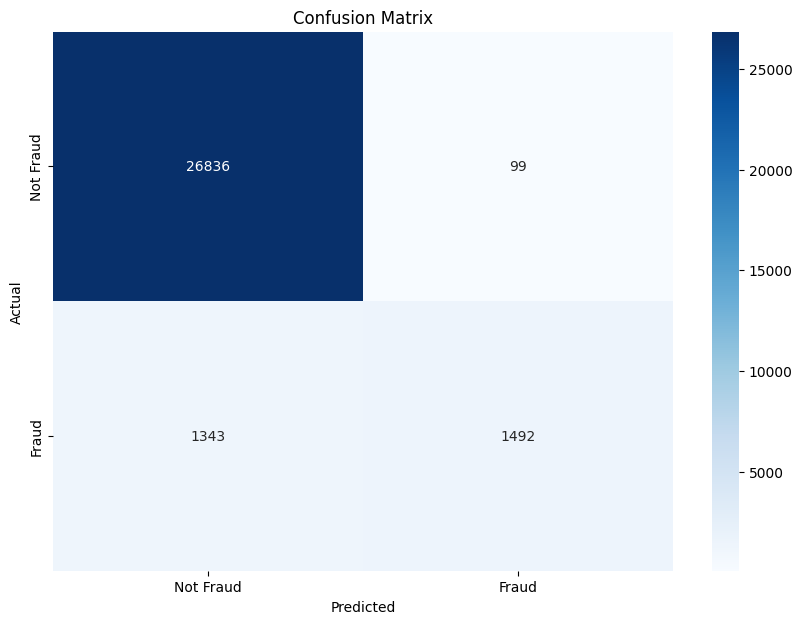

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(y_test, prediction)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [2]:
import shap
print(shap.__version__)


0.46.0


In [ ]:
# Initialize SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_scaled)

In [ ]:
# Summary Plot
shap.summary_plot(shap_values[1], X_test, feature_names=X.columns)

In [ ]:
# Force Plot (for first instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test.iloc[0, :])

In [ ]:
# Dependence Plot
shap.dependence_plot('transaction_amount', shap_values[1], X_test, feature_names=X.columns)

In [ ]:
# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled, 
    feature_names=X.columns, 
    class_names=['Non-Fraud', 'Fraud'], 
    mode='classification'
)


In [ ]:
# Explain a single instance
idx = 0  # Index of instance to explain
exp = explainer.explain_instance(X_test_scaled[idx], model.predict_proba, num_features=10)

In [ ]:
# Feature Importance Plot
exp.show_in_notebook()

print("Model explainability using SHAP and LIME is complete.")